<a href="https://colab.research.google.com/github/sciencebyAJ/OpenET_API_Training/blob/main/IA_2025_OpenET_Raster_MultiPolygon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://drive.google.com/uc?export=view&id=1_TxtLd2mqSKnuwQwTV-py5Q55A6gB97d">

# **Multipolygon Time Series via the API**

## [raster/multipolygon/timeseries](https://openet.gitbook.io/docs/reference/api-reference/raster#post-raster-timeseries-multipolygon)

#### This notebook provides a step-by-step guide to access multi-polygon time series data from the OpenET API.




> * The multi-polygon endopint supports timeseries queries against OpenET's raster datasets summarized for multiple polygons specified by an Earth Engine asset ID or temporary uploaded GeoJSON file. For more information on Earth Engine assets, see the [Earth Engine page](https://openet.gitbook.io/docs/additional-resources/earth-engine).



> * The results of this endpoint will generate a 5 minute retrieval link for a .CSV file. Each request will include the spatial aggregation of your choice with the area and volume of each polygon. See FAQ for requirements for an asset ID.
* For large regions, please use Export Multipolygon.







## Pre-requisites to complete this notebook


1.   **[An OpenET account](https://account.etdata.org/login)**
2.   An OpenET **[API key](https://account.etdata.org/settings/api)**
3. A multi-polygon GeoJSON.

>   * Convert a shapefile to GeoJSON using **[MapShaper](https://mapshaper.org/)**.
  * Evaluate GeoJSON compatibility with OpenET data servicesusing **[GeoJSONLint](https://geojsonlint.com/)**




# Outline


[1](https://colab.research.google.com/drive/1D8reBMNteEzQe6NldfhCPFZFLrJ2VxW4#scrollTo=sTU0slM2Hnta&line=1&uniqifier=1).   **Import Python dependencies & Configure API Key**


[2](https://colab.research.google.com/drive/1D8reBMNteEzQe6NldfhCPFZFLrJ2VxW4#scrollTo=YvyaRQXRTAdo&line=19&uniqifier=1).   **Load boundary as GeoJSON**

3.  **Make API Requests**: Construct and send a request to upload geometry & to retrieve ET data.

4.   **Save & Analyze data**: Load and process the retrieved raster data for analysis.

In [2]:
!git clone https://github.com/sciencebyAJ/OpenET_API_Training.git --quiet

In [1]:
#@title Import Python dependencies & Configure API Key:
import requests
import pandas as pd
import getpass
import matplotlib.pyplot as plt

In [3]:
# @markdown ## API Key { run: "auto" }

# @markdown ### Go to your [OpenET API account](https://account.etdata.org/settings/api) page and copy the API Key.

# @markdown ### Then paste your API Key below after running this cell

YOUR_API_KEY = getpass.getpass("Paste your API key here --> ")


Paste your API key here --> ··········


In [4]:
#@title Assign API Key to header
header = {"Authorization": YOUR_API_KEY}

### Upload a GeoJSON to extract data

* 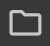 Click the folder icon to the left.

* 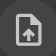 Click on the upload file icon and select the geojson from your computer.

* After the file appears in the content/ folder, right click the file & select `Copy path`

* Past the text to the `path_to_geojson: PATH/TO/sample.geojson` box below








> * GeoJSONS are limited to files < 5MB.
* For the *Utah-API* GeoJSONS can have 2000 polygons and up to 1,000,000 acres.

*Before moving on, open the Geojson inspect the attributes to pass to the attributes parameter of the API query.*

In [5]:
#@title Select GeoJSON to upload for data extraction

path_to_geojson = "/content/OpenET_API_Training/geospatial_data/UT_fields_demo.geojson" #@param {type:"string"}

# endpoint arguments
args = {
    'file': (path_to_geojson, open(path_to_geojson, 'rb'), 'application/geo+json')
}

# query the api
resp = requests.post(
    headers=header,
    files=args,
    url="https://openet-api.org/account/upload"
)


asset_path = resp.json()['asset_id']


print(resp.json())
print('The asset_id is assigned to asset_path')


{'asset_id': 'https://storage.googleapis.com/openet-api-public/AJ_Purdy_263/190548e40d634353bb4582194e3f989c', 'expires': '72 hours'}
The asset_id is assigned to asset_path


The link is a time to live link that expires in 72 hours.

## Query the Multipolygon Time Series endpoint to retrieve OpenET data

### raster/multipolygon/timeseries

### **input parameters**
*   **date_range**: start and end dates formatted as: `["YYYY-MM-DD","YYYY-MM-DD"]`
*   **file_format**: returned file format accepted as `"JSON"` or `"CSV"`
*   **interval**: frequency of ETaw and Peff data being returned. Accepted inputs `"daily"` or `"monthly"`
*   **asset_id**: earth engine asset path OR path to temporary cloud asset_id
* **attributes**: List of feature attributes to include in extraction. Must include a unique identifier for each polygon.
*   **model**: OpenET ET model to use as an input to the OTTER model. Accepted parameters include `"Ensemble"`, `"geeSEBAL"`, `"SSEBop"`, `"SIMS"`, `"DisALEXI"`, `"PTJPL"`, or `"eeMETRIC"`.
*   **reference ET**: Source collection for ET reference. Choose from CIMIS (California only) or gridMET. NOAA's forecasted reference ET FRET can now be used for 7 day forecasts.
* **reducer**: Pixel aggregation method. Choose from min, max, mean, median, mode, or sum.
*   **units**: Output units. Choose from `"in"` or `"mm" `


### return
* The results of this endpoint will generate a 5 minute retrieval link for a .CSV file.


In [44]:
#@title Pass arguments to API

args = {
    "date_range": [
        "2019-10-01",
        "2022-09-30"
        ],
    "interval": "daily",
    "asset_id": asset_path,
    "attributes": [
        "field_id",
        "crop_type"],
    "model": "eemetric",
    "variable": "et",
    "reference_et": "gridMET",
    "reducer": "mean",
    "units": "in"
}

# query the api
resp = requests.post(
    headers=header,
    json=args,
    url="https://openet-api.org/raster/timeseries/multipolygon"
)

# store the result
export = resp.json()

print('This link can be accessed for 5 minutes ')
print(export['url'])

df = pd.read_csv(export['url'], parse_dates=["time"])
df.to_csv('openet_multi-polygon_timeseries.csv', index=False)

This link can be accessed for 5 minutes 


KeyError: 'url'

In [43]:
#@title Now get precipitation

args = {
    "date_range": [
        "2019-10-01",
        "2022-09-30"
        ],
    "interval": "daily",
    "asset_id": asset_path,
    "attributes": [
        "field_id",
        "crop_type"],
    "model": "eemetric",
    "variable": "pr",
    "reference_et": "gridMET",
    "reducer": "mean",
    "units": "in"
}

# query the api
resp = requests.post(
    headers=header,
    json=args,
    url="https://openet-api.org/raster/timeseries/multipolygon"
)

# store the result
export = resp.json()

print('This link can be accessed for 5 minutes ')
print(export['url'])

pr_df = pd.read_csv(export['url'], parse_dates=["time"])


This link can be accessed for 5 minutes 


KeyError: 'url'

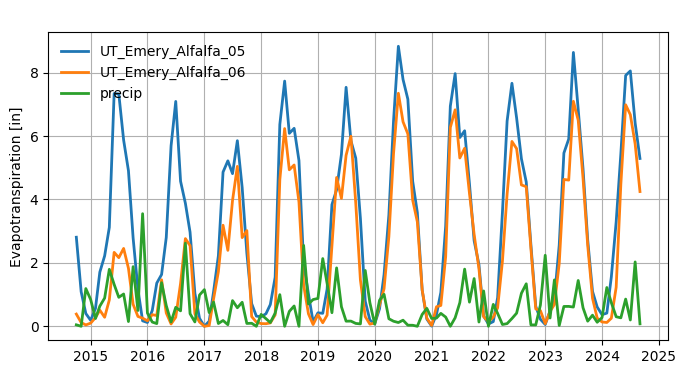

In [35]:
#@title Plot ET data in depth to compare fields from 2014 to present

df_pivot = df.pivot(index='time', columns='field_id', values='et')
pr_df_pivot = pr_df.pivot(index='time', columns='field_id', values='pr')
pr_df_pivot.columns = [col + '_precip' for col in pr_df_pivot.columns]
combined_df = pd.concat([df_pivot, pr_df_pivot['UT_Emery_Alfalfa_05_precip']], axis=1)
combined_df= combined_df.rename(columns={'UT_Emery_Alfalfa_05_precip': 'precip'})



plt.figure(figsize=(8, 4))
for column in combined_df.columns:
    plt.plot(combined_df.index, combined_df[column], label=column, linewidth=2)

plt.ylabel("Evapotranspiration [in]")
plt.xlabel("") # Remove x-axis label
plt.title(" ")
plt.legend(frameon=False)
plt.grid(True)
plt.show()

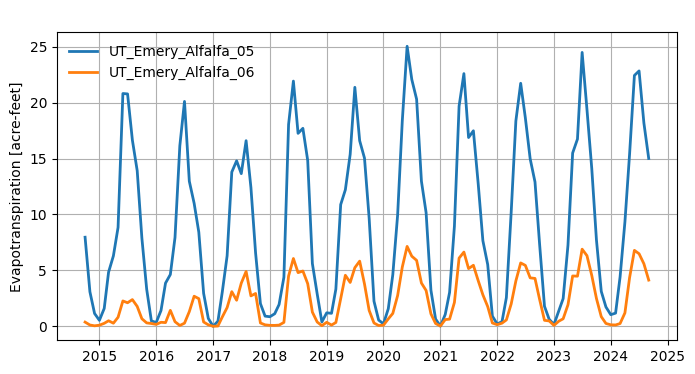

In [36]:
#@title Plot ET data in volume [acre-ft]
df_pivot = df.pivot(index='time', columns='field_id', values='acre-feet')
plt.figure(figsize=(8, 4))
for column in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[column], label=column, linewidth=2)

plt.ylabel("Evapotranspiration [acre-feet]")
plt.xlabel("") # Remove x-axis label
plt.title(" ")
plt.legend(frameon=False)
plt.grid(True)
plt.show()

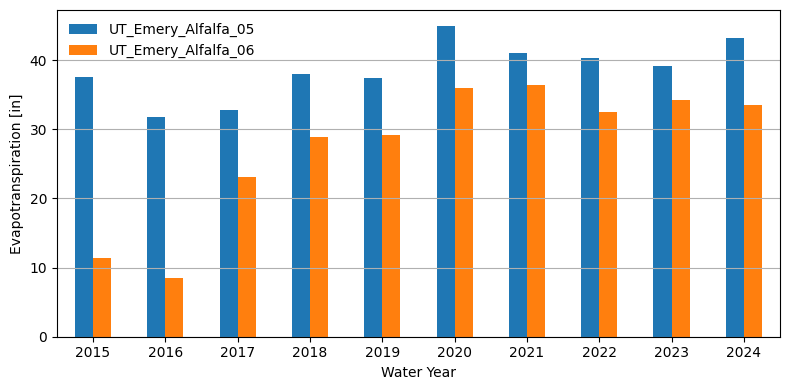

In [37]:
#@title Plot total ET depth by water year
# assign water year to time series
df['wy'] = df.time.dt.year + (df.time.dt.month >= 10).astype(int)
# group by water year and field
wateryear_df = df[['et','wy','field_id']].groupby(['wy','field_id']).sum().reset_index()

# plot data
plt.figure(figsize=(8, 4))
wateryear_df.pivot(index='wy', columns='field_id', values='et').plot(kind='bar', ax=plt.gca())
plt.ylabel("Evapotranspiration [in]")
plt.xlabel("Water Year")
plt.legend(frameon=False)
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.grid(axis='y')

In [40]:
# @title Read in corresponding time series of applied water data
field_id = '05'
df_irr = pd.read_csv(f'/content/OpenET_API_Training/geospatial_data/UT_Emery_Alfalfa_ETaw_Field_{field_id}.csv')
df_irr['date'] = pd.to_datetime(df_irr['date'])
df_irr.set_index('date', inplace=True)
# df_all = pd.merge(df, df_irr, left_index=True, right_index=True, how='inner')
# Set adjusted water year
# df_all['wy'] = df_all.index.year + (df_all.index.month >= 11).astype(int)

/tmp/ipython-input-672506306.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_irr['date'] = pd.to_datetime(df_irr['date'])


In [42]:
df_irr

,aw_acft
date,
2019-01-01,0.012153
2019-01-02,0.009391
2019-01-03,0.003130
2019-01-04,0.000000
2019-01-05,0.000000
...,...
2022-12-27,0.000000
2022-12-28,0.000000
2022-12-29,0.000000
